In [23]:
%matplotlib inline
import seaborn as sns
import quandl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from arctic import Arctic

import math
from core import *
from datetime import datetime
import statsmodels.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

F	January
G	February
H	March
J	April
K	May
M	June
N	July
Q	August
U	September
V	October
X	November
Z	December

In [2]:
list_of_markets=['C','JM','I','M','BB','J','CS','PP','L','V','JD','P','A','Y','B','FB']
list_of_months = ['F','G','H','J','K','M','N','Q','U','V','X','Z']

# Soybeans

In [3]:
ddf={}
mini_list = list(list_of_months)
for y in range(2018,2012,-1):
    for m in mini_list:
        try:
            ddf[m + str(y)[2:]]=quandl.get('DCE/M' + m + str(y),authtoken=token)[['Close','Volume','Turnover','Open Interest']]
        except:
            mini_list.remove(m)
            print 'Missing '+m + ' '+ str(y)

Missing G 2018
Missing J 2018
Missing M 2018
Missing Q 2018
Missing V 2018
Missing Z 2018


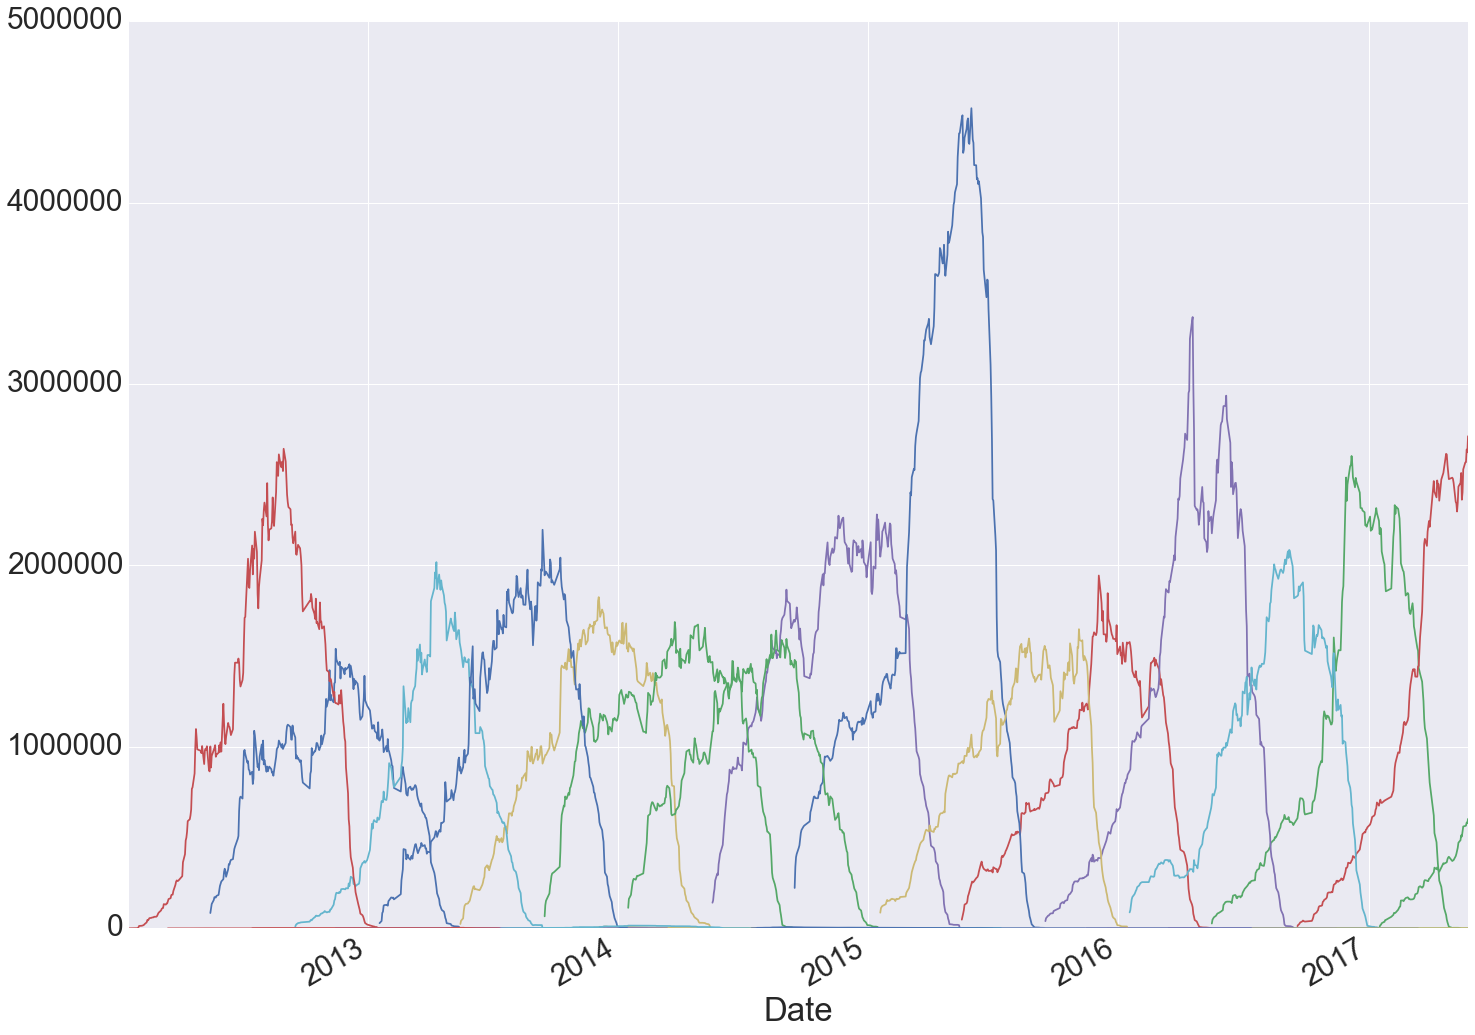

In [4]:
f, ax = plt.subplots()
for k in ddf.keys():
    if ddf[k].Volume.max() > 1:
        ddf[k]['Open Interest'].plot(ax=ax)

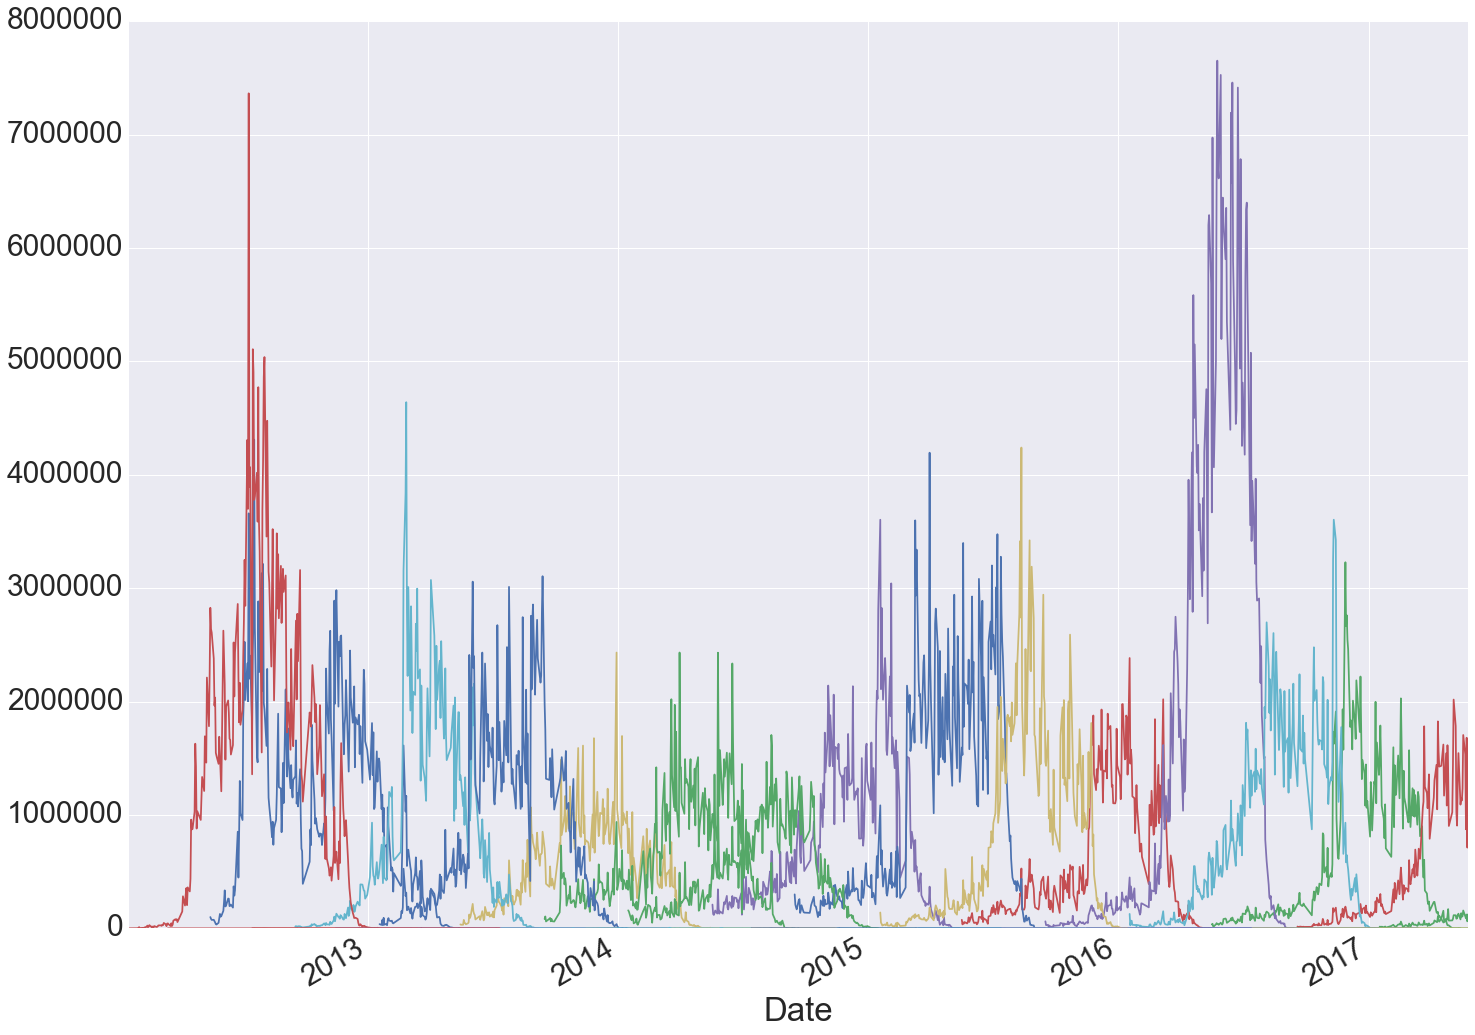

In [5]:
f, ax = plt.subplots()
for k in ddf.keys():
    if ddf[k].Volume.max() > 1:
        ddf[k]['Volume'].plot(ax=ax)

In [6]:
ix = pd.DatetimeIndex(start=datetime(2000, 1, 1), end=datetime(2018, 12, 31), freq='D')
price=pd.DataFrame(index=ix)
for k in ddf.keys():
    price[k]=ddf[k].Close
price=price.dropna(how='all')

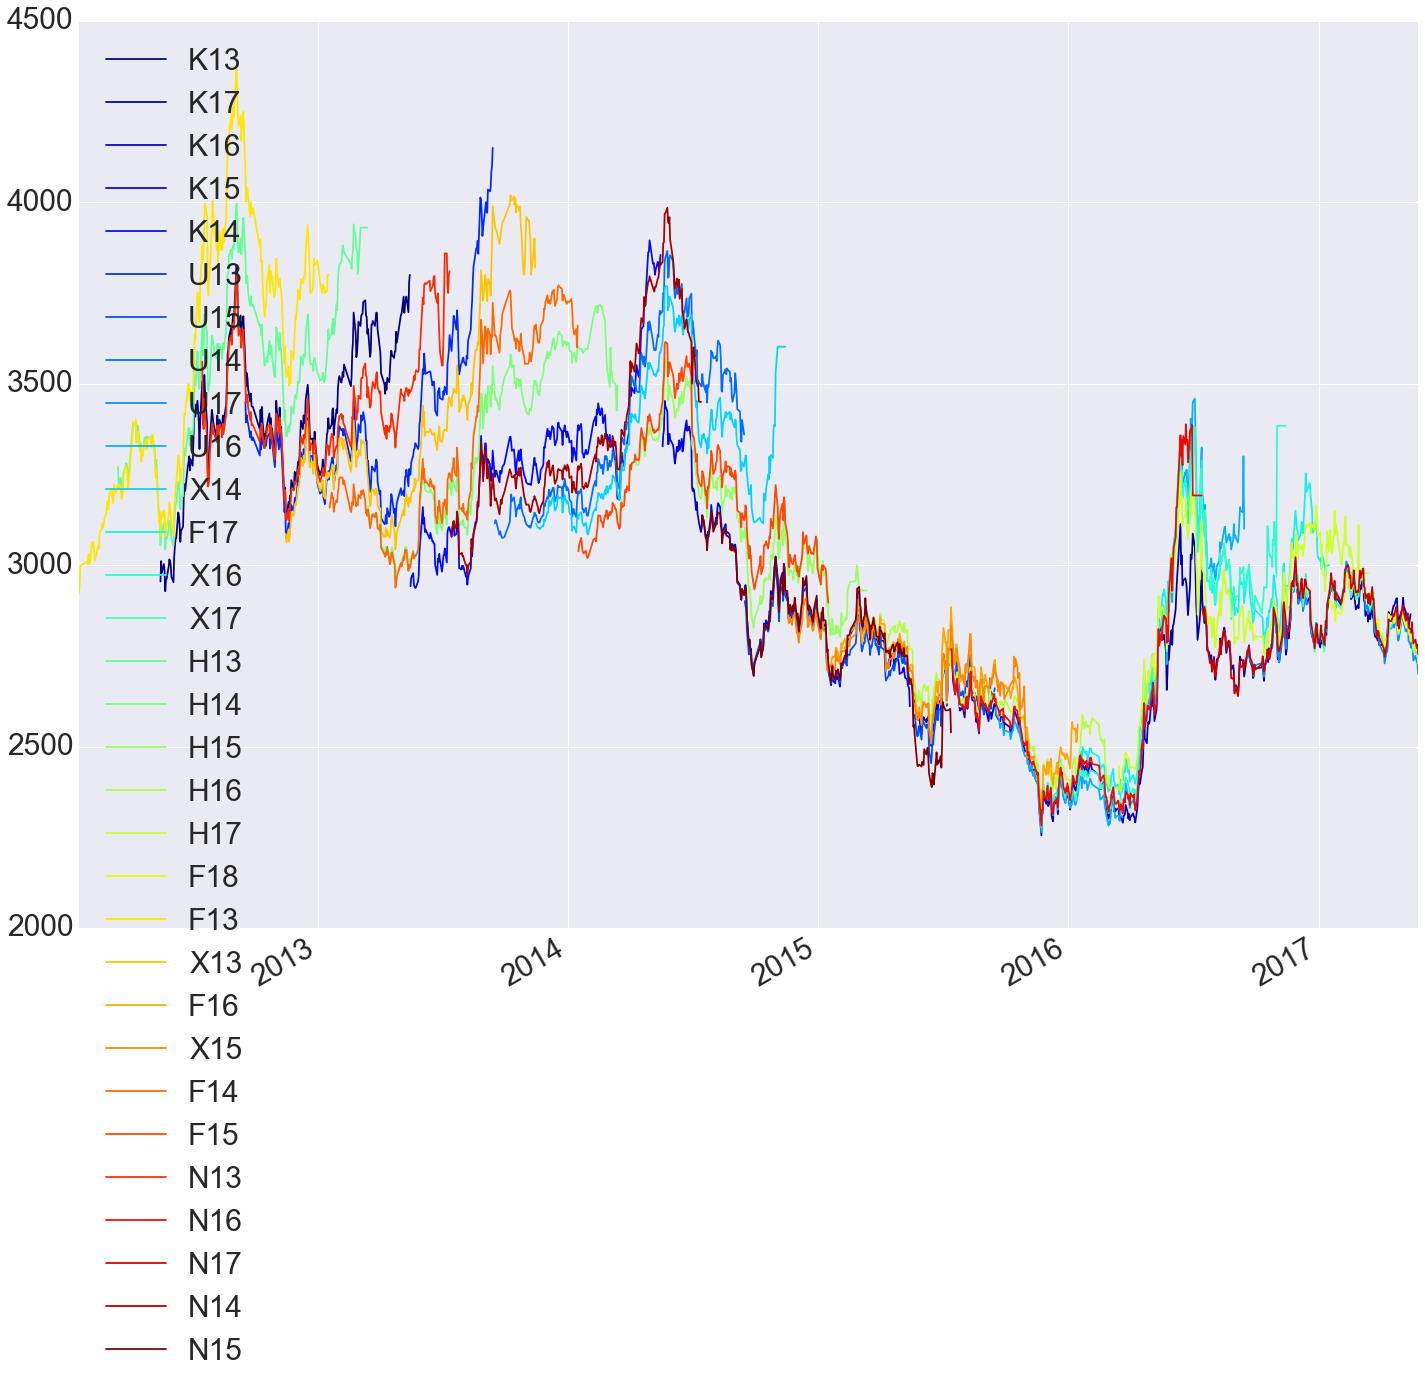

In [7]:
price.plot(colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


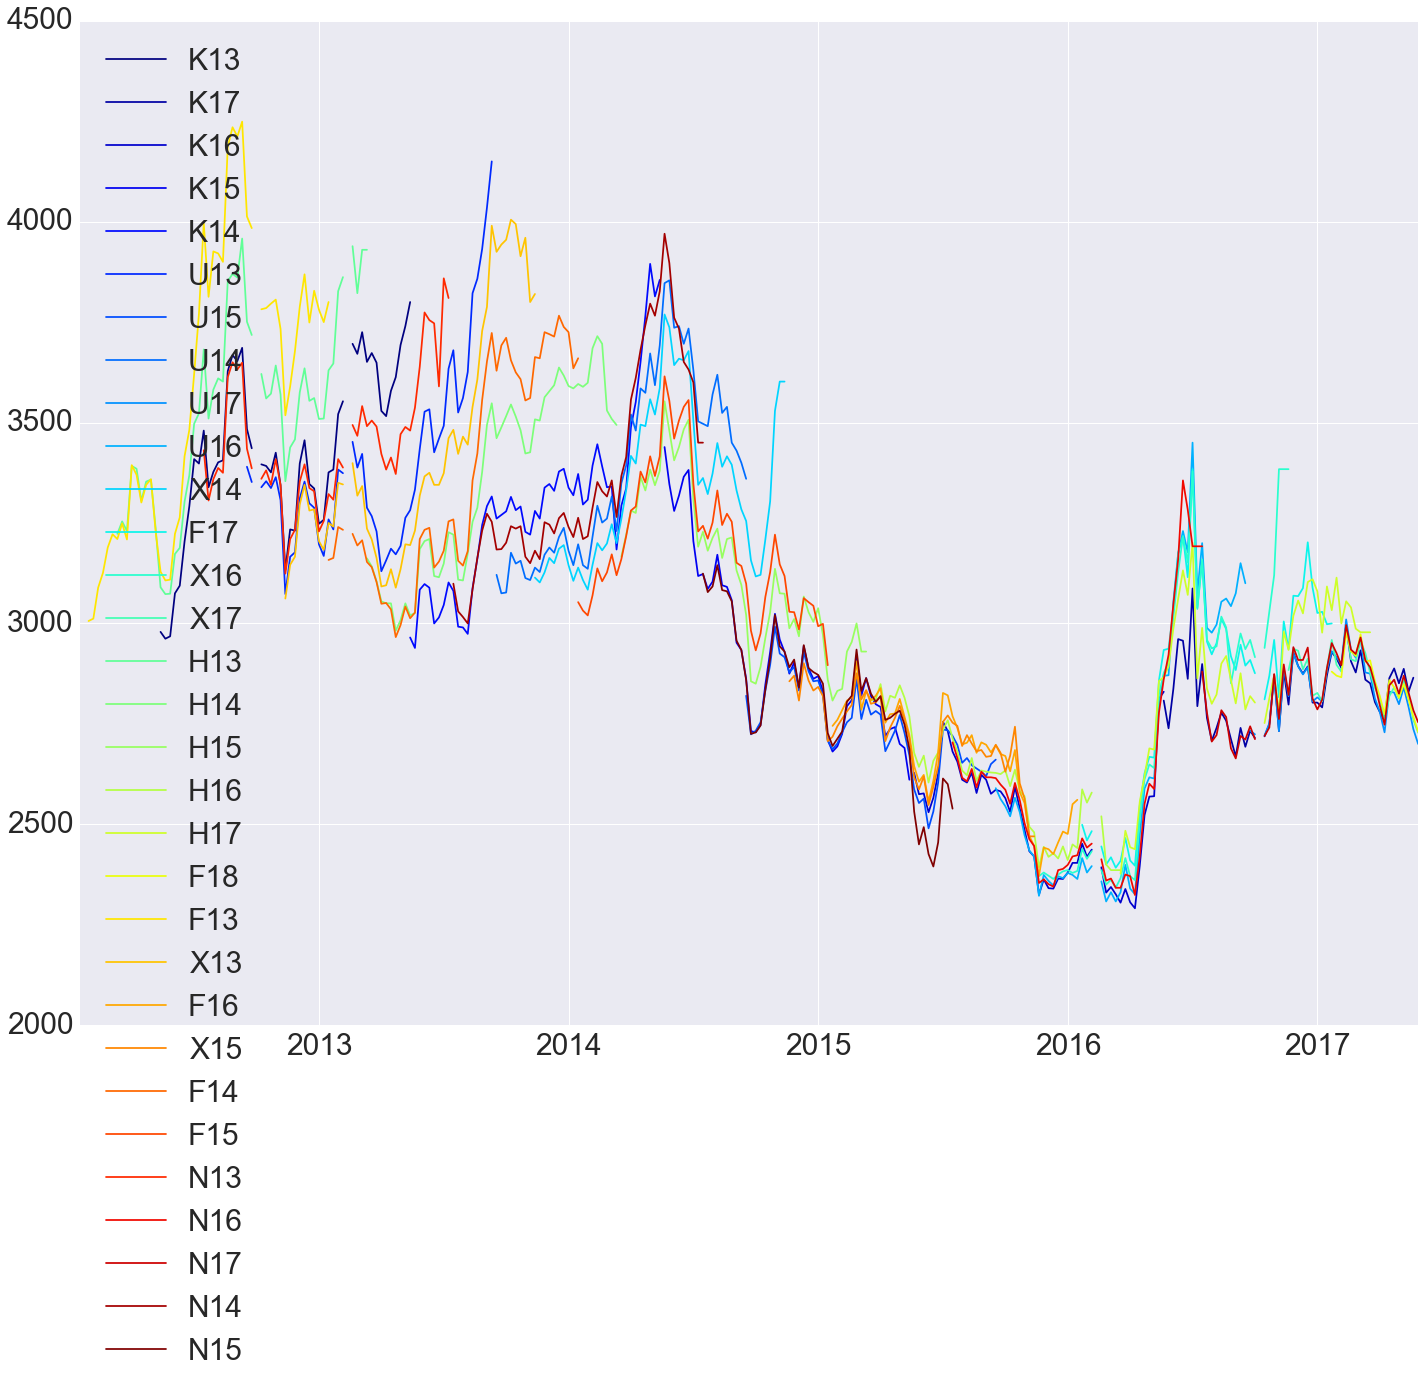

In [8]:
price.resample(rule='w3',how='last').plot(colormap='jet')

In [9]:
ix = pd.DatetimeIndex(start=datetime(2000, 1, 1), end=datetime(2018, 12, 31), freq='D')
volume=pd.DataFrame(index=ix)
for k in ddf.keys():
    volume[k]=ddf[k]['Open Interest']
volume=volume.dropna(how='all')

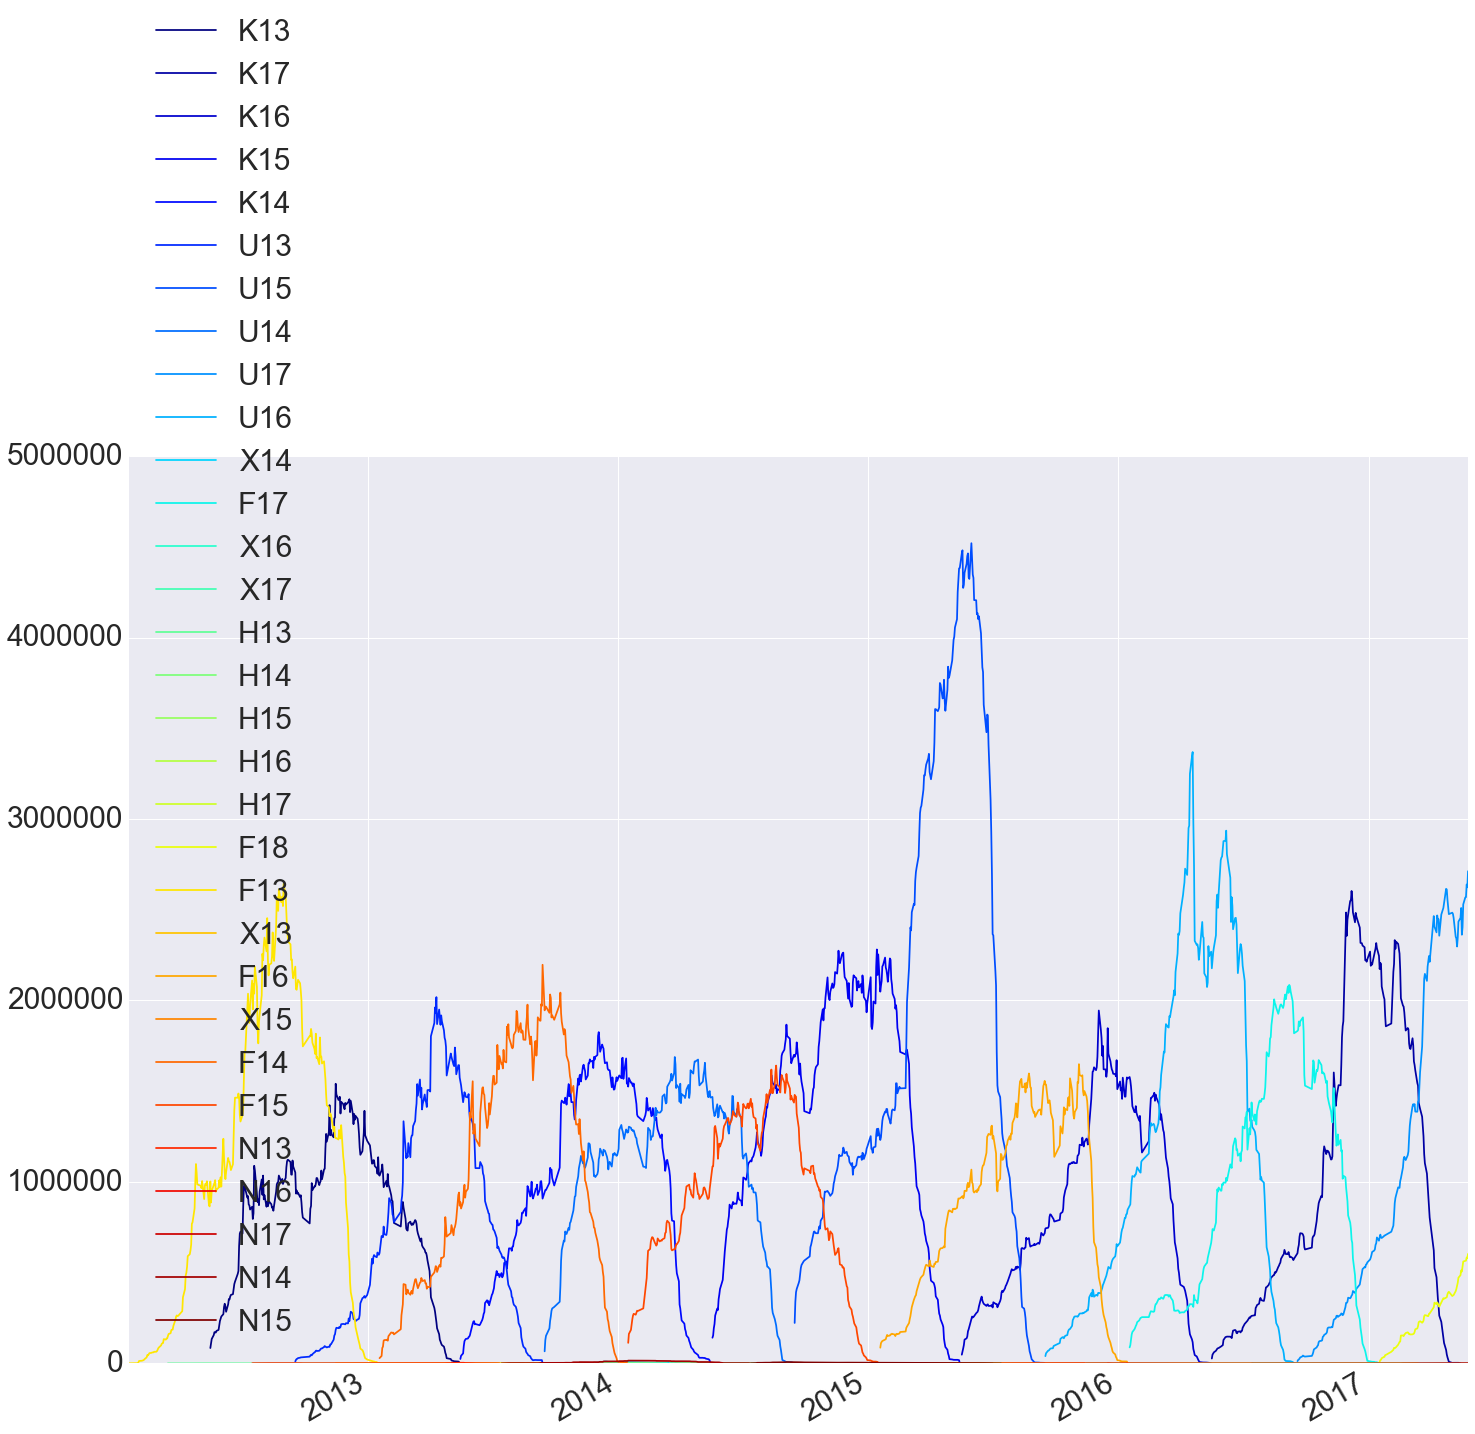

In [10]:
volume.plot(colormap='jet')

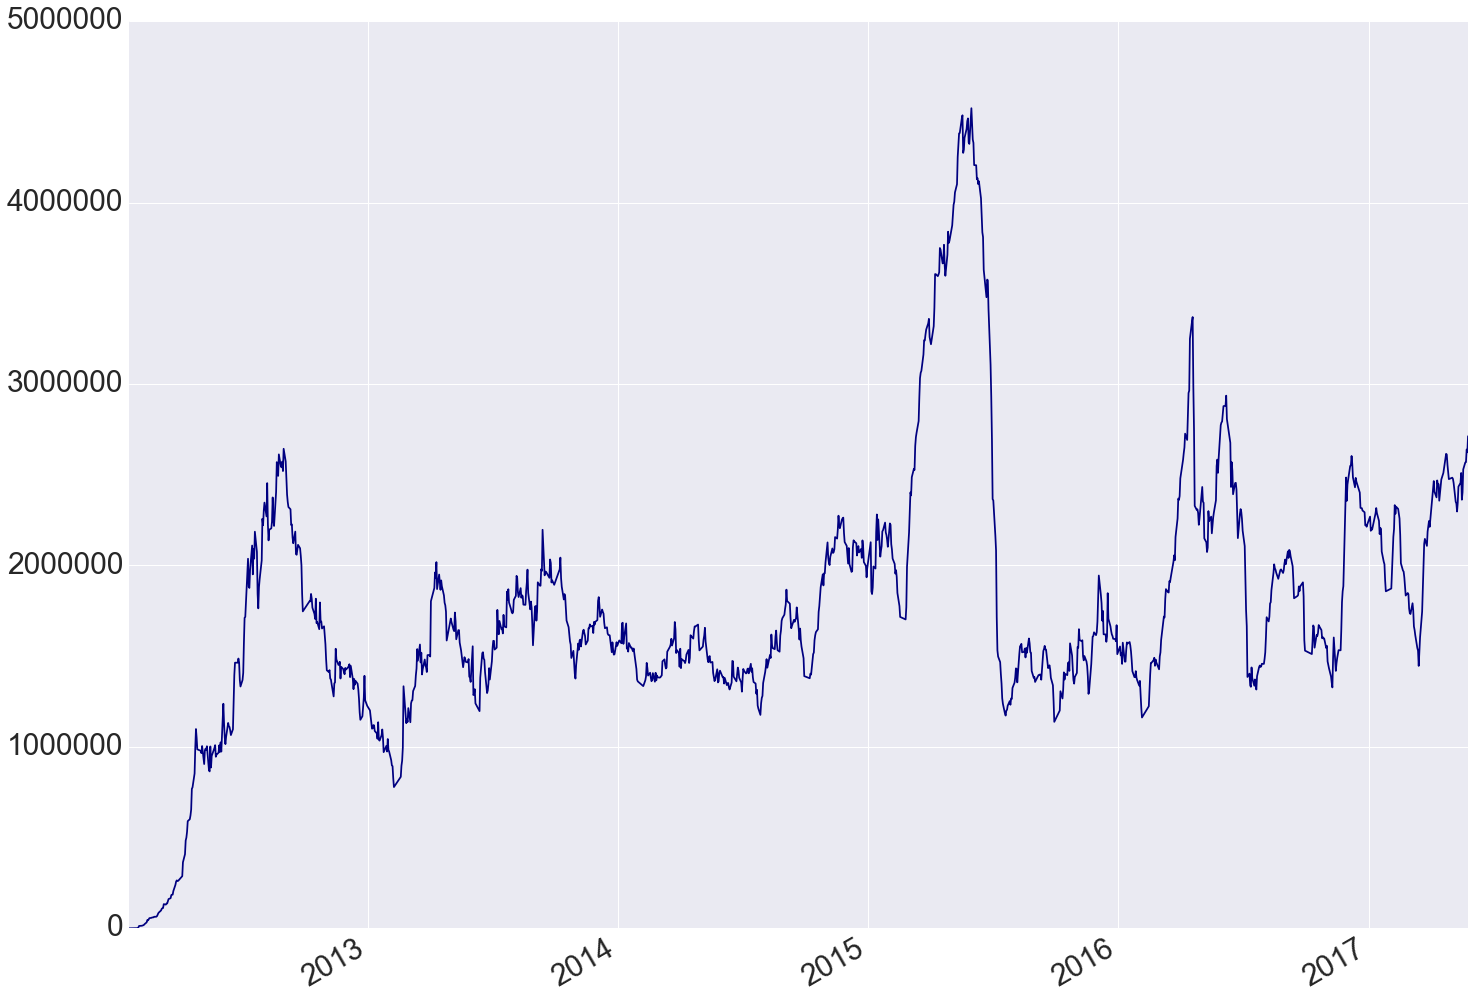

In [11]:
volume.max(axis=1).plot(colormap='jet')

# Stiching process
Uses open interest as the measure to switch.  

* Need to understand what to do with spreads

In [12]:

ww=volume.apply(lambda s: s.nlargest(2).index.tolist(), axis=1)
s=ww.copy()
mon='XXX'
spread=0
for ind, val in ww.iteritems():
    if val[0]==mon:
        s.ix[ind]=price[val[0]].ix[ind]
    else:
        print ind, val,spread
        s.ix[ind]=price[val[0]].ix[ind]+spread
    mon=val[0]
    if len(val)==2:
        spread=price[val[0]].ix[ind]-price[val[1]].ix[ind]
    

2012-01-18 00:00:00 ['F13'] 0
2012-11-06 00:00:00 ['K13', 'F13'] 394.0
2012-11-07 00:00:00 ['F13', 'K13'] -356.0
2012-11-13 00:00:00 ['K13', 'F13'] 372.0
2013-02-08 00:00:00 ['U13', 'K13'] 162.0
2013-05-30 00:00:00 ['F14', 'U13'] 233.0
2013-05-31 00:00:00 ['U13', 'F14'] -208.0
2013-06-03 00:00:00 ['F14', 'U13'] 224.0
2013-06-04 00:00:00 ['U13', 'F14'] -247.0
2013-06-05 00:00:00 ['F14', 'U13'] 291.0
2013-10-31 00:00:00 ['K14', 'F14'] 312.0
2014-02-24 00:00:00 ['U14', 'K14'] 140.0
2014-06-09 00:00:00 ['F15', 'U14'] 276.0
2014-06-16 00:00:00 ['U14', 'F15'] -235.0
2014-06-25 00:00:00 ['F15', 'U14'] 136.0
2014-06-27 00:00:00 ['U14', 'F15'] -145.0
2014-06-30 00:00:00 ['F15', 'U14'] 178.0
2014-07-24 00:00:00 ['K15', 'F15'] 111.0
2014-07-29 00:00:00 ['F15', 'K15'] -144.0
2014-08-14 00:00:00 ['K15', 'F15'] 136.0
2014-08-18 00:00:00 ['F15', 'K15'] -150.0
2014-08-26 00:00:00 ['K15', 'F15'] 187.0
2015-02-26 00:00:00 ['U15', 'K15'] 54.0
2015-07-22 00:00:00 ['F16', 'U15'] -50.0
2015-11-20 00:00:00 [

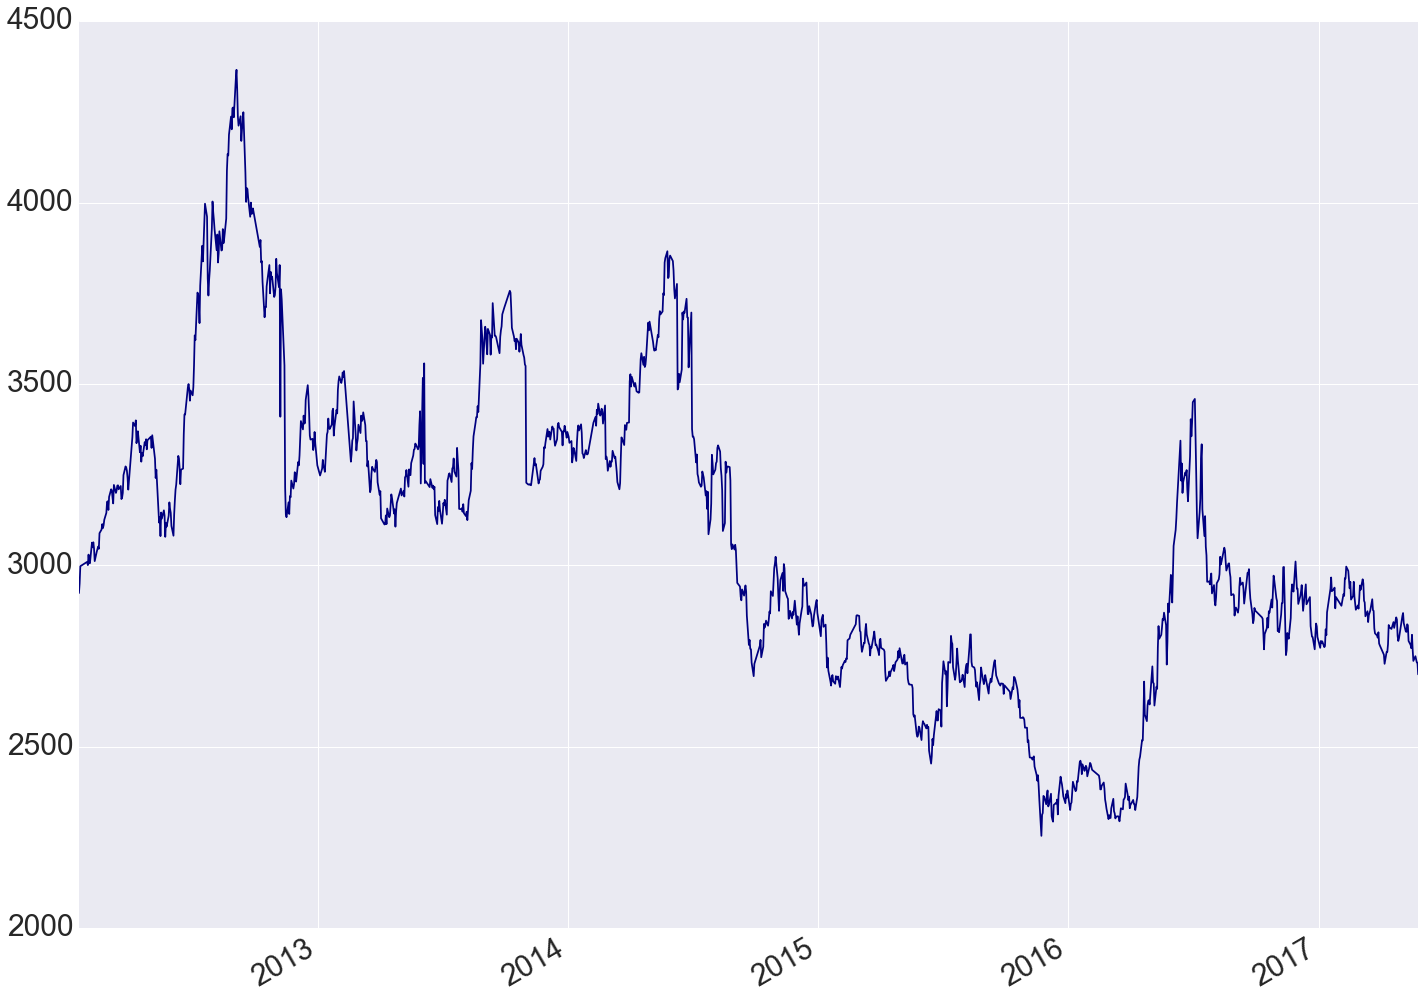

In [13]:
s.plot(colormap='jet')

In [14]:
def compare(last,this):
    if this[1:]>last[1:] or this[0] > last[0]:
        return this
    else:
        return last

In [15]:
def adjusted_returns(price,volume):
    rtn=price.pct_change()
    ww=volume.apply(lambda s: s.nlargest(2).index.tolist(), axis=1)
    s=ww.copy()
    mon='A00'
    spread=0
    for ind, val in ww.iteritems():
        mon=compare(mon,val[0])
        s.ix[ind]=rtn[val[0]].ix[ind]
    return s

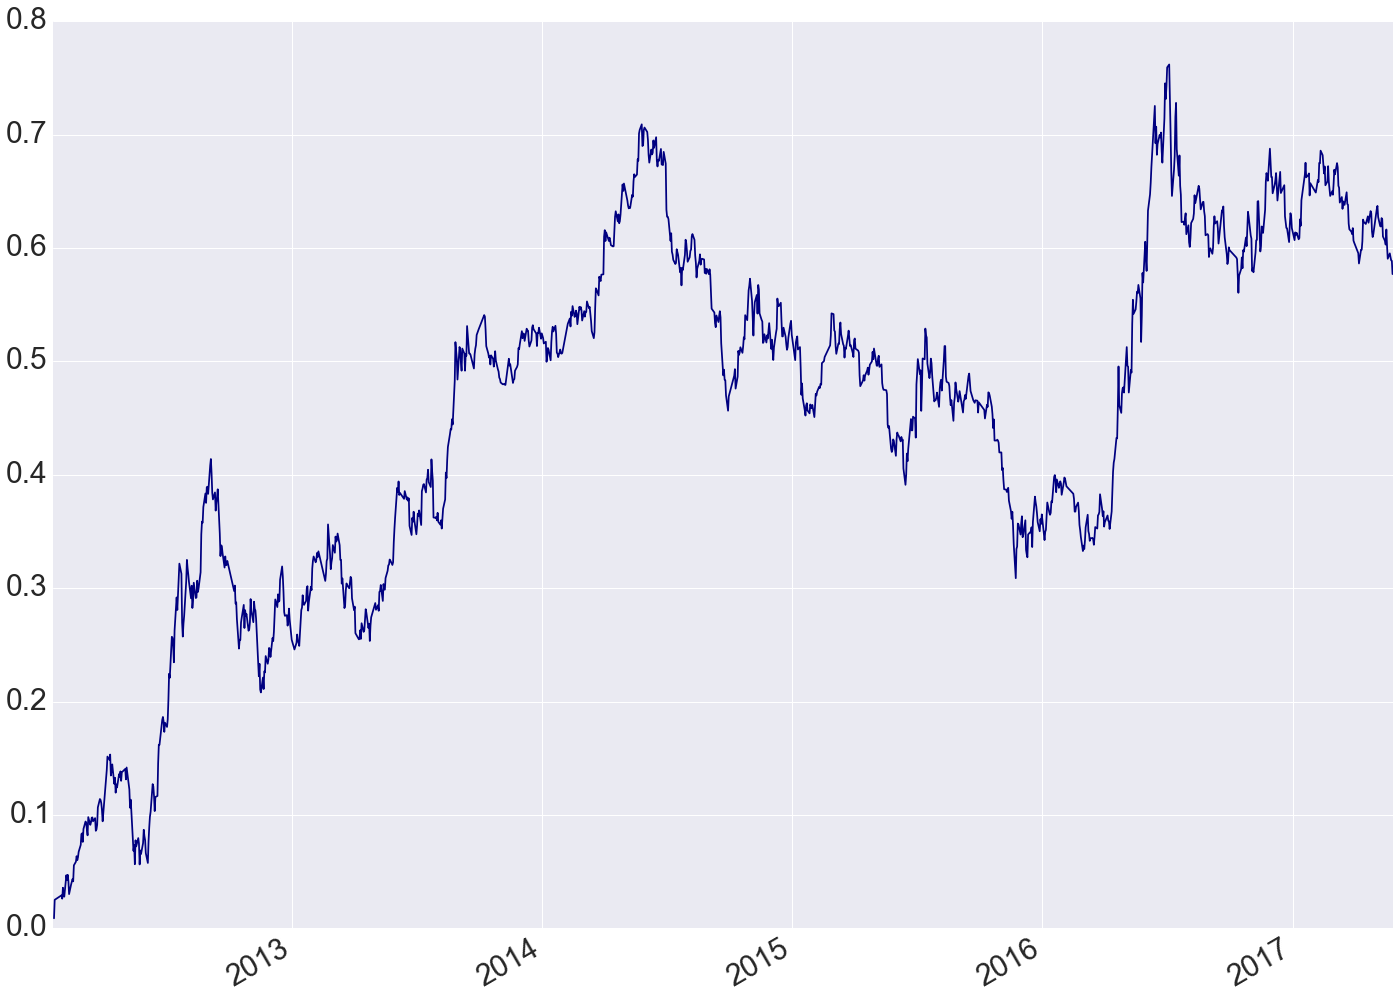

In [16]:
adjusted_returns(price,volume).cumsum().plot(colormap='jet')

# Arctic

In [19]:
# Using Arctic database to store
store = Arctic('localhost')
# Access the library
store.initialize_library('CHINA_OI')

price_table = store['CHINA_PX']
OI_table = store['CHINA_OI']


In [25]:
# Market Load
mkt='Soybeans'
price_table.write(mkt, price, metadata={'ticker': 'DCE/M','exchange':'DCE'})


VersionedItem(symbol=Soybeans,library=arctic.CHINA_PX,data=<type 'NoneType'>,version=3,metadata={'ticker': 'DCE/M', 'exchange': 'DCE'}

In [21]:
OI_table.write(mkt, volume, metadata={'ticker': 'DCE/M','exchange':'DCE'})

VersionedItem(symbol=Soybeans,library=arctic.CHINA_OI,data=<type 'NoneType'>,version=2,metadata={'ticker': 'DCE/M', 'exchange': 'DCE'}

In [26]:
get_timeseries(mkt).cumsum().plot()


NameError: global name 'mkt' is not defined

In [27]:
position=tsmom_daily(data,250)
pnl=calc_pnl(position,data).dropna()

NameError: name 'data' is not defined

In [ ]:
df=pd.DataFrame()
df['Pos']=position.dropna()
df['Price']=data.dropna().cumsum()
df['PNL']=pnl.dropna().cumsum()
df.plot(secondary_y='Price')

In [ ]:
calc_Sharpe(pnl,260)

In [ ]:
pnl.std()*16

In [ ]:
position=ewma_mom_daily(data,20,60)
pnl=calc_pnl(position,data).dropna()
df=pd.DataFrame()
df['Pos']=position.dropna()
df['Price']=data.dropna().cumsum()
df['PNL']=pnl.dropna().cumsum()
df.plot(secondary_y='Price')

In [ ]:
pnl.std()*16


In [ ]:
signal.plot()

In [ ]:
(signal/pd.rolling_std(signal,250)).dropna().plot()

In [ ]:
get_timeseries('BB').cumsum().plot()